In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import itertools
from pathlib import Path
import os

2022-05-31 19:29:48.445949: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Tamanho imagem
img_rows, img_cols = 224, 224

input_shape = (img_rows, img_cols, 3)

# Batch size

batch_size = 32

# seed
seed = 42

path_dataset = Path('/scratch/dpfurtado/backup_home/corais/5_subimage_224_224/dataset/1_train_50/')
path_test = path_dataset/'test_1_2'

path_modelo = './model/resnet_plc_full_transfer/'

In [3]:
test_dataset = image_dataset_from_directory(
        path_test,
        image_size=(img_rows, img_cols),
        color_mode="rgb",
        batch_size=batch_size,
        shuffle=False)

Found 247 files belonging to 8 classes.


2022-05-31 19:29:51.134340: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-31 19:29:51.136676: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-31 19:29:52.036847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: NVIDIA GeForce GTX TITAN Black computeCapability: 3.5
coreClock: 0.98GHz coreCount: 15 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 312.92GiB/s
2022-05-31 19:29:52.037475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: NVIDIA GeForce GTX TITAN Black computeCapability: 3.5
coreClock: 0.98GHz coreCount: 15 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 312.92GiB/s
2022-05-31 19:29:52.037516: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcu

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
#Otimização
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
model = tf.keras.models.load_model(path_modelo)
y_pred_proba = model.predict(test_dataset)
y_pred = np.argmax(y_pred_proba, axis=1)

2022-05-31 19:30:16.599690: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-31 19:30:16.620859: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz
2022-05-31 19:30:19.613250: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-31 19:30:19.759978: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [6]:
y_test = np.concatenate([y for x, y in test_dataset], axis=0)

In [7]:
from sklearn.metrics import log_loss
soft_preds=tf.nn.softmax(y_pred_proba).numpy()
log_loss(y_test, soft_preds)

0.8345540664759138

In [8]:
np.save('./resultados/pred_proba_resnet101_plc.npy', soft_preds)

In [9]:
acc = accuracy_score(y_test, y_pred)
print("Acurácia: {:.4f}".format(acc))

Acurácia: 0.7368


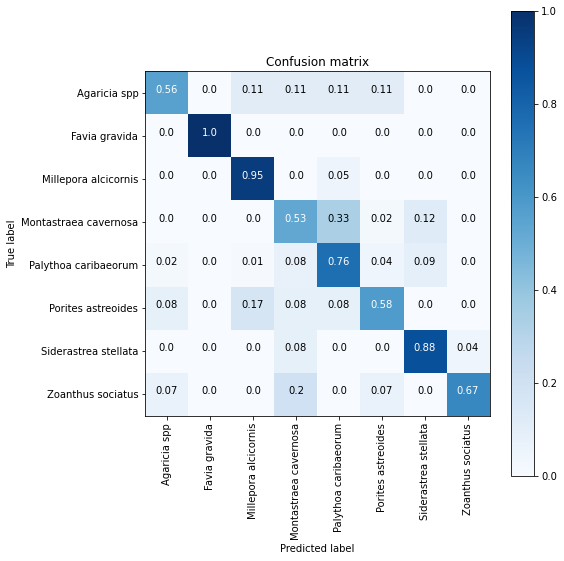

In [10]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
      cm (array, shape = [n, n]): a confusion matrix of integer classes
      class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    # Compute the labels from the normalized confusion matrix.
    labels = np.around(cm, decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

class_names = ['Agaricia spp', 'Favia gravida', 'Millepora alcicornis', 'Montastraea cavernosa', 'Palythoa caribaeorum', 'Porites astreoides', 'Siderastrea stellata', 'Zoanthus sociatus']

# Calculate the confusion matrix.
cm = confusion_matrix(y_test, y_pred, normalize='true')
# Log the confusion matrix as an image summary.
figure = plot_confusion_matrix(cm,class_names)


In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56         9
           1       1.00      1.00      1.00         4
           2       0.90      0.95      0.93        40
           3       0.66      0.53      0.59        51
           4       0.77      0.76      0.77        92
           5       0.50      0.58      0.54        12
           6       0.60      0.88      0.71        24
           7       0.91      0.67      0.77        15

    accuracy                           0.74       247
   macro avg       0.74      0.74      0.73       247
weighted avg       0.74      0.74      0.73       247



In [12]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

In [13]:
print(f1_score(y_test, y_pred, average='macro'))
print(matthews_corrcoef(y_test, y_pred))

0.7317406728079636
0.6644030210903815
